# В этом туториале разберёмся с предобученными эмбеддингами и обработкой данных в `torch`

## Источники

- [fasttext](https://fasttext.cc/docs/en/crawl-vectors.html) для 157 языков
- [RusVectores](https://rusvectores.org/ru/models/) – собрание предобученных эмбеддингов для русского языка на любой вкус *
- Также мы можем предобучить эмбеддинги на своих данных, но об этом в следующих сериях :)

-----

\* В моделях RusVectores в большинстве своём содержатся не сами слова и их векторы, а слово+частеречный тег (например, `мама_NOUN [вектор]` , что не так удобно в использовании для наших целей, но может пригодиться вам в исследованиях на других курсах. [Вот тут](https://github.com/RaRe-Technologies/gensim-data/issues/3) можно посмотреть как загружать модели RusVectores

----
Скачиваем и распаковываем fasttext

In [1]:
## Раскомментируйте и скачайте эмбеддинги
# !wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
# !gzip -d cc.ru.300.vec.gz

## Чтение файла

In [2]:
emb_file = open('cc.ru.300.vec')

num_words, emb_dim = emb_file.readline().split()
num_words, emb_dim = int(num_words), int(emb_dim)
emb_file.close()
print(f'num_words: {num_words}, \nemb_dim: {emb_dim}')

num_words: 2000000, 
emb_dim: 300


Для примера возьмём задачу классификации на датасете [cedr](https://huggingface.co/datasets/cedr). Скачиваем и предобрабатываем датасет. В обучающих целях возьмем только те тексты, для которых определён ровно 1 класс (там встречаются примеры, для которых определены 0 классов или больше 1, они нам не нужны)

In [3]:
from string import punctuation

from datasets import load_dataset
import matplotlib.pyplot as plt
from nltk.tokenize import ToktokTokenizer
import numpy as np
from tqdm import tqdm
import torch
import seaborn as sns

In [4]:
punct = punctuation + "«»"

### Токенизация
Процесс разбиения текста на токены, то есть части этого текста.   
Чем "слово" отличается от "токена": токен это более обобщенное понятие, то есть токенами являются не только слова, но еще и цифры, даты, смайлики и тд.

In [5]:
tokenizer = ToktokTokenizer()

In [6]:
tokenizer.tokenize('Привет! Как твои дела? Чем ты занимаешься ??? =))')

['Привет',
 '!',
 'Как',
 'твои',
 'дела',
 '?',
 'Чем',
 'ты',
 'занимаешься',
 '??',
 '?',
 '=',
 ')',
 ')']

In [7]:
corpus = load_dataset('cedr')

No config specified, defaulting to: cedr/main
Reusing dataset cedr (/Users/a19415907/.cache/huggingface/datasets/cedr/main/0.1.1/117570489cbabbdf8de619bd31918a1cd680a7f286b89d04af340d0691dc2d66)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
texts = list()
labels = list()

for text, label in zip(corpus['train']['text'], corpus['train']['labels']):
    if len(label) == 1:
        texts.append(text)
        labels.append(label[0])
        
len(texts)

4378

In [9]:
print(f'В датасете {len(set(labels))} классов')

В датасете 5 классов


Мы хотим использовать эмбеддинги для векторизации текстов. Но если мы просто прочитаем весь файл, в котором 2 миллиона векторов размерностью 300, это всё может не поместиться в память. Поэтому будем держать в памяти только вектора тех слов, которые реально есть в наших текстах. Мы прочитаем 100 000 первых слов и возьмем к ним эмббединги.

----

_Примечание_. Чем больше слов мы прочитаем, тем меньше шанс того, что мы не сможем обработать какое-то слово на проде. Так что здесь необходим компромисс.

In [12]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with open(file_path) as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
        max_words = vocab_size if max_words <= 0 else max_words

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [13]:
vocab, embeddings = load_embeddings('cc.ru.300.vec', max_words=100_000)

Reading embeddings file: 100%|█████████▉| 99998/100000 [00:08<00:00, 12371.74it/s]


In [14]:
embeddings.shape

(100000, 300)

## UNK

В текстах есть неизвестные фасттексту токены. Их мы можем удалять или заменять на токен UNK. В данном случае возьмём в качестве неизвестного вектора вектор из единиц – это просто условность. 

Если бы мы не планировали дообучать вектора, то вместо UNK могли бы взять:
- какой-то очень редкий токен из word2vec, который точно не встретится в текстах
- среднее по нескольким эмбеддингам

Но с этим могут возникнуть проблемы, поэтому надёжнее было бы просто выкидывать неизвестный токен

In [15]:
index2token = {index: token for token, index in vocab.items()}

In [16]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [17]:
def get_k_nearest_neighbors(word, embeddings, emb_norms, vocab, index2token, k=5):
    
    if word not in vocab:
        print('Not in vocab')
        return
    
    word_index = vocab[word]

    word_vector = embeddings[word_index]
    word_vector = np.expand_dims(word_vector, 0)

    scores = (word_vector @ embeddings.T)[0]
    
    # переводим в косинусы, поделив на нормы векторов
    # эпсилон 1e-6 для того, чтобы не делить на 0
    scores = scores / (emb_norms + 1e-6) / emb_norms[word_index]
    
    # 1:k+1 потому что первый вариант это само слово
    for idx in scores.argsort()[::-1][1:k+1]:
        print(f'Слово {index2token[idx]} близко на {scores[idx]:.2f} к слову {word}')

In [18]:
get_k_nearest_neighbors('аня', embeddings, emb_norms, vocab, index2token)

Слово таня близко на 0.91 к слову аня
Слово катя близко на 0.91 к слову аня
Слово оля близко на 0.90 к слову аня
Слово настя близко на 0.89 к слову аня
Слово юля близко на 0.89 к слову аня


In [19]:
get_k_nearest_neighbors('мама', embeddings, emb_norms, vocab, index2token)

Слово бабушка близко на 0.83 к слову мама
Слово мамочка близко на 0.80 к слову мама
Слово дочка близко на 0.78 к слову мама
Слово мать близко на 0.75 к слову мама
Слово тетя близко на 0.74 к слову мама


In [20]:
get_k_nearest_neighbors('имею', embeddings, emb_norms, vocab, index2token)

Слово имеете близко на 0.71 к слову имею
Слово имеешь близко на 0.69 к слову имею
Слово имел близко на 0.67 к слову имею
Слово имея близко на 0.63 к слову имею
Слово могу близко на 0.62 к слову имею


In [21]:
get_k_nearest_neighbors('деньги', embeddings, emb_norms, vocab, index2token)

Слово денежки близко на 0.82 к слову деньги
Слово бабки близко на 0.69 к слову деньги
Слово денежные близко на 0.67 к слову деньги
Слово бабло близко на 0.65 к слову деньги
Слово денег близко на 0.65 к слову деньги


In [22]:
get_k_nearest_neighbors('музыка', embeddings, emb_norms, vocab, index2token)

Слово мелодия близко на 0.71 к слову музыка
Слово песня близко на 0.67 к слову музыка
Слово музыку близко на 0.62 к слову музыка
Слово поэзия близко на 0.61 к слову музыка
Слово аранжировка близко на 0.61 к слову музыка


## Сравним разные способы токенизации

In [23]:
# про различия подробнее можно найти, например, здесь
# https://stackoverflow.com/questions/50240029/nltk-wordpunct-tokenize-vs-word-tokenize
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [24]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация по пробелу
    tokens = sample.split()
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 4378/4378 [00:00<00:00, 108848.68it/s]

Мы не знаем 16672 слов из 56988 слов в датасете
Что составляет 29.26% датасета

Уникальных неизвестных слов: 11918


In [25]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация
    tokens = wordpunct_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 4378/4378 [00:00<00:00, 64473.38it/s]

Мы не знаем 13043 слов из 66991 слов в датасете
Что составляет 19.47% датасета

Уникальных неизвестных слов: 7295


In [26]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация
    tokens = word_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 4378/4378 [00:00<00:00, 7208.14it/s]

Мы не знаем 11407 слов из 69058 слов в датасете
Что составляет 16.52% датасета

Уникальных неизвестных слов: 7279


In [27]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация
    tokens = tokenizer.tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 4378/4378 [00:00<00:00, 17375.28it/s]

Мы не знаем 11604 слов из 68007 слов в датасете
Что составляет 17.06% датасета

Уникальных неизвестных слов: 7806


### В данном примере в качесте компромисса между скоростью и качеством возьмем `ToktokTokenizer()`

# Torch Dataset, DataLoader

Очень важная абстракция для торча.
Мы всегда будем ее использовать, чтобы работать с данными.

Dataset - класс, от которого нужно наследоваться, чтобы написать свой обработчик данных. Внутри него нужно реализовать два метода, 
о которых будет чуть ниже. То есть в данном классе вы описывает как нужно преобразовать ваши данные в торчовый формат. Перевести тексты 
в индексы слов и тд.

DataLoader - класс, который будет за вас семплировать данные батчами. Это итератор, поэтому формат работы с ним примерно такой:
```python
for batch in data_loader:
    ...
```
То есть на каждой итерации отдается по одному батчу данных. Итерирование заканчивается, когда вы пройдете все батчи.

Зачем нужны эти абстракции? Чтобы упростить и унифицировать работу с данными.
Вообще вы можете реализовать что-то свое, но это упрощение данной задачи.

In [28]:
from torch.utils.data import Dataset, DataLoader

In [29]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [30]:
# просто рандомные цифры
some_data_x[:10]

array([[0.08390985, 0.73901492, 0.53839731, 0.08602887],
       [0.65902384, 0.44442405, 0.94237867, 0.73012484],
       [0.89205426, 0.62401704, 0.56258677, 0.8085014 ],
       [0.28957367, 0.92751064, 0.44624601, 0.38509372],
       [0.20312296, 0.99569099, 0.29115095, 0.18119811],
       [0.20123462, 0.90599464, 0.86329834, 0.68147875],
       [0.97337525, 0.383089  , 0.3071032 , 0.79541952],
       [0.13137745, 0.88181408, 0.25298212, 0.10445733],
       [0.81206587, 0.50075849, 0.09746288, 0.08488478],
       [0.65241757, 0.42343821, 0.35027859, 0.55469096]])

In [31]:
# и классы
some_data_y

array([2, 1, 0, ..., 1, 1, 2])

### Пример надобности
Для обучения модели вам нужно подавать в нее батчи данных. Как бы могли это реализовать, если бы у нас не было Dataset и DataLoader

In [32]:
batch_size = 16

for start_batch in tqdm(range(0, some_data_x.shape[0], batch_size)):
    
    # выделили подвыборку для x и y
    x_batch = some_data_x[start_batch:start_batch + batch_size]
    y_batch = some_data_y[start_batch:start_batch + batch_size]
    
    # перевели numpy.array в torch.Tensor
    x_batch = torch.Tensor(x_batch)
    y_batch = torch.Tensor(y_batch)

100%|██████████| 7596/7596 [00:00<00:00, 63592.05it/s]


In [33]:
x_batch

tensor([[0.3988, 0.3867, 0.7535, 0.1573],
        [0.9263, 0.8980, 0.9717, 0.0502],
        [0.6780, 0.1598, 0.2096, 0.8795],
        [0.2334, 0.8950, 0.9819, 0.5237],
        [0.8297, 0.0650, 0.5640, 0.1436],
        [0.8200, 0.0888, 0.8296, 0.5728],
        [0.3732, 0.5296, 0.4542, 0.6237],
        [0.8561, 0.3099, 0.7064, 0.5035],
        [0.8445, 0.7229, 0.9940, 0.8948],
        [0.8224, 0.0968, 0.1955, 0.2978],
        [0.4032, 0.4686, 0.4744, 0.9936],
        [0.8036, 0.2887, 0.4401, 0.5896],
        [0.5311, 0.7239, 0.3884, 0.2194],
        [0.0986, 0.7204, 0.7350, 0.5810],
        [0.9766, 0.0980, 0.1361, 0.5313]])

Это достаточно простой пример. Мы смогли справиться сами, но почти всегда обработка данных для подачи ее в модель делается сложнее. 
И некоторые вещи часто нужны более одного раза, например, если мы хотим каждую эпоху шафлить наши данные, чтобы получать разные батчи.
Мы сможем это сделать, но для этого нам придется тащить с собой некоторый код из проекта в проект. К тому же совместная разработка или 
просто чтение чужого кода сильно упрощается, когда вы используете унифицированные форматы.

### Перейдем к Dataset
И обернем наши данные в этот обработчик

In [34]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # нужно обязательно определить эту функцию
        # должна возвращать размер датасета
        # нужен для DataLoader, чтобы семплировать батчи
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # еще нужно определить этот метод
        # то есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [35]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [36]:
some_dataset[5], some_dataset[467]

((array([0.20123462, 0.90599464, 0.86329834, 0.68147875]), 1),
 (array([0.53292551, 0.8284627 , 0.20675282, 0.79202086]), 2))

### Кажется, что смысла в этом нет, но это самый простой пример

### DataLoader
В него мы можем задать некоторые параметры, например, батч сайз и нужно ли шафлить каждый новый проход по данным эти самые данные, 
чтобы получать разные батчи, то есть по разному компоновать эти батчи

In [37]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [38]:
for x, y in some_loader:
    break
    
x

tensor([[0.0743, 0.3899, 0.2710, 0.1958],
        [0.4043, 0.2142, 0.6954, 0.2143],
        [0.9368, 0.6142, 0.6360, 0.4866],
        [0.0268, 0.1752, 0.0502, 0.4007],
        [0.2839, 0.9535, 0.4708, 0.4747],
        [0.8043, 0.9568, 0.9653, 0.5936],
        [0.6977, 0.5088, 0.9580, 0.7959],
        [0.1141, 0.9250, 0.4151, 0.7939],
        [0.4814, 0.1534, 0.4067, 0.6722],
        [0.4097, 0.2172, 0.0530, 0.3716],
        [0.1891, 0.5164, 0.3446, 0.3382],
        [0.5903, 0.6094, 0.9152, 0.9172],
        [0.8977, 0.5235, 0.6368, 0.9912],
        [0.2054, 0.4076, 0.3539, 0.4153],
        [0.1628, 0.0358, 0.2724, 0.0508],
        [0.7283, 0.3156, 0.9479, 0.7058]], dtype=torch.float64)

In [39]:
x.shape

torch.Size([16, 4])

In [40]:
for x, y in some_loader:
    pass

len(x)

15

In [41]:
# почему 15?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

### Усложним обработчик

Для чего это все? Внутри датасета мы можем делать все что угодно с нашими данными, см. функцию `__getitem__`

In [42]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # нужно обязательно определить эту функцию
        # должна возвращать размер датасета
        # нужен для DataLoader, чтобы семплировать батчи
        
        return len(self.data_x)
    
    @staticmethod
    def pow_features(x, n=2):
        
        return x ** n
    
    @staticmethod
    def log_features(x):
        
        return np.log(x)
    
    def __getitem__(self, idx):
        
        # еще нужно определить этот метод
        # то есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x_p_2 = self.pow_features(x, n=2)
        x_p_3 = self.pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x_log = self.log_features(x)
        
        # сконкатенируем наши фичи
        x = np.concatenate([x, x_p_2, x_p_3, x_log])
        
        y = self.data_y[idx]
        
        return x, y

In [43]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [44]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [45]:
for x, y in toy_loader: # заметим, что мы сразу получаем торчовый формат данных
    break

In [46]:
x.shape

torch.Size([128, 16])

In [47]:
x

tensor([[ 0.0839,  0.7390,  0.5384,  ..., -0.3024, -0.6192, -2.4531],
        [ 0.6590,  0.4444,  0.9424,  ..., -0.8110, -0.0593, -0.3145],
        [ 0.8921,  0.6240,  0.5626,  ..., -0.4716, -0.5752, -0.2126],
        ...,
        [ 0.2980,  0.5527,  0.0765,  ..., -0.5930, -2.5701, -0.1711],
        [ 0.2624,  0.9566,  0.0393,  ..., -0.0444, -3.2358, -0.4102],
        [ 0.8782,  0.6737,  0.2707,  ..., -0.3949, -1.3068, -1.7048]],
       dtype=torch.float64)

In [48]:
y

tensor([2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2,
        2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2,
        2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2,
        2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 2, 2, 0,
        2, 2, 1, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1,
        1, 1, 0, 0, 1, 2, 2, 0])

In [49]:
# сделаем небольшую модель и посчитаем лосс

model = torch.nn.Sequential(torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3))

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.114852786064148

## Перейдем к нашим текстам
Будем отдавать строку и таргет по индексу

In [50]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        
        text = self.texts[index]
        target = self.targets[index]
        
        return text, target

In [51]:
dataset = TextClassificationDataset(texts=texts, targets=labels)

In [52]:
x, y = dataset[5]

In [53]:
x

'/ С этим удивительным и снежным утром!'

In [54]:
y

0

### Смысл обработчика
Состоит в том, что нам нужно преобразовать наши данные в формат, который мы уже сможем передать в модель.
Сейчас у нас строки, а торч ничего не знает про строки, ему нужны тензоры.

### Загружаем эмбеддинги
Чтобы работать с текстовыми данными мы можем разбить наши строки на слова, а слова перевести в вектора. Мы говорили про такой метод как word2vec и в начале этой тетрадки загружали файл с этими самыми векторами.

In [105]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, tokenizer):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        НАПИСАТЬ КОД САМОМУ
        """
        ...
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        НАПИСАТЬ КОД САМОМУ
        """
        ...

    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        # применить реализованные методы
        tokenized_text = ...
        
        # переведем наши индексы токенов в торчовый тензор
        # таргет переведется самостоятельно
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [106]:
dataset = TextClassificationDataset(texts=texts, targets=labels, vocab=vocab, tokenizer=tokenizer)

In [107]:
x, y = dataset[5]

In [108]:
x

[18, 400, 29198, 4, 2311, 22]

In [109]:
y

0

In [113]:
# мы можем восстановить текст обратно по индексам слов
[index2token[idx.item()] for idx in x]

['меня',
 'остается',
 'только',
 'один',
 'вопрос',
 '-',
 'является',
 'ли',
 'этот',
 'приступ',
 'отчаяния',
 '(',
 'а',
 'точнее',
 'приступ',
 'удивления',
 ',',
 'почему',
 'мне',
 'не',
 'становится',
 'лучше',
 ',',
 'почему',
 'мне',
 'ничего',
 'не',
 'помогает',
 ')',
 'еще',
 'одним',
 'испытанием',
 '?']

### У нас остается проблема разных длин текстов
Чтобы поместить батч текстов в один тензор нам нужны одинаковые длины

In [114]:
## это не отработает, можете раскомментировать и проверить

# x = [
#     [1, 2, 3],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5, 6, 7]
# ]

# torch.tensor(x), torch.tensor(x).shape

In [115]:
# это сработает

x = [
    [1, 2, 3, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 0, 0],
    [1, 2, 3, 4, 5, 6, 7]
]

torch.tensor(x), torch.tensor(x).shape

(tensor([[1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 4, 5, 0, 0],
         [1, 2, 3, 4, 5, 6, 7]]),
 torch.Size([3, 7]))

### Длина текста
Нам нужно понять до какой длины нам падить каждый наш пример. 
Мы можем найти в наших данных максимальную длину примера в токенах и падить до этой длины, но у этого подхода есть минус:
у нас могут быть несколько текстов с аномально большой длиной, то есть некоторые выбросы.  

В таком случае нам легче ограничить длину этих текстов до определенной статистики по нашему датасет, то есть, например, 95% наших текстов
длиной в 25 слов и нам этого достаточно. То есть мы ограничимся этой длиной, потому что почти весь датасет влезает в эту длину
и нам не нужно будет падить до большой длины.

Паддинг нужен нам для того, чтобы мы могли поместить разные примеры в один батч, но мы не хотим учитывать эти токены, то есть 
по сути это будут холостые прогоны и за счет этого компромисса, что бОльшая часть датасета не больше n слов мы можем оптимизировать 
наше обучение.

<br>


> Почему бы нам просто не выкинуть эти длинные тексты?

Дело в том, что мы хотим прийти к некоторому компромиссу между максимальной длиной и потерей информации. Если мы возьмем 95-й перцинтиль наших длин (то есть 95% наших текстов не больше n), то, выкинув остальные 5%, мы потеряем существенную часть примеров.
С другой стороны может показаться неправильным ограничение длины и это действительно может сломать смысл примеры, но зачастую этим 
принебрегают.

In [116]:
lengths = [len(tokenizer.tokenize(sample)) for sample in tqdm(texts)]

100%|██████████| 4378/4378 [00:00<00:00, 19076.23it/s]


<AxesSubplot:title={'center':'Распределение длин'}, xlabel='Длина в токенах', ylabel='Count'>

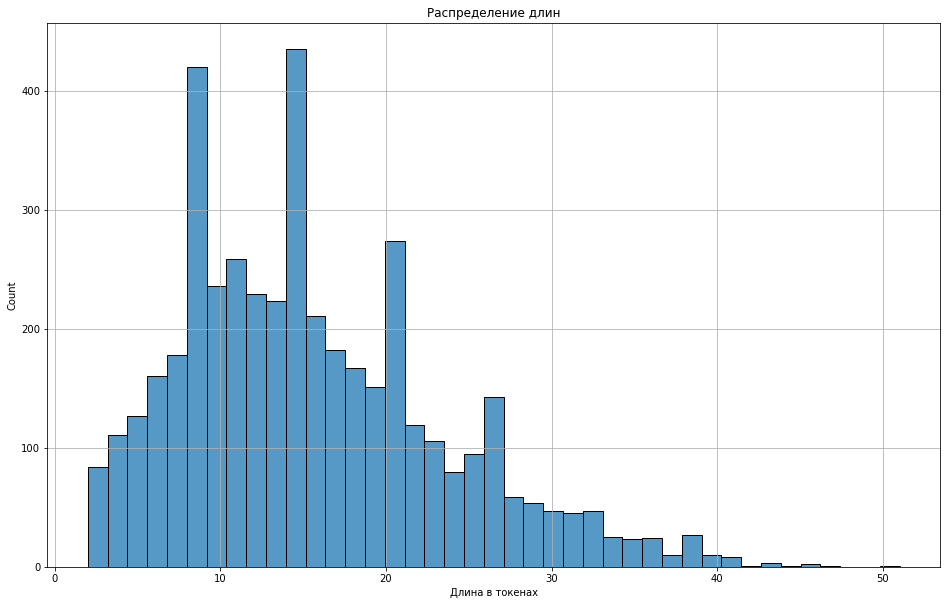

In [117]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.title("Распределение длин")
plt.xlabel("Длина в токенах")
sns.histplot(lengths)

In [118]:
# видим большие выбросы в данных
# 97% наших текстов не больше вот стольки токенов
np.percentile(lengths, 97)

34.0

In [126]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, tokenizer, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.tokenizer = tokenizer
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        ...
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        ...
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        ...
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        # применить реализованные методы
        tokenized_text = ...
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [127]:
dataset = TextClassificationDataset(texts=texts, targets=labels, vocab=vocab, tokenizer=tokenizer)

In [128]:
x, y = dataset[0]
x

tensor([  117,  1404,    56,   150,   283,    16,   124,   143,   148, 26614,
        30773,     9,    28,  4495, 26614, 27742,     2,   551,   135,    13,
          762,   287,     2,   551,   135,   309,    13,  1666,     8,    96,
          554, 44141])

In [129]:
[index2token[idx.item()] for idx in x]

['меня',
 'остается',
 'только',
 'один',
 'вопрос',
 '-',
 'является',
 'ли',
 'этот',
 'приступ',
 'отчаяния',
 '(',
 'а',
 'точнее',
 'приступ',
 'удивления',
 ',',
 'почему',
 'мне',
 'не',
 'становится',
 'лучше',
 ',',
 'почему',
 'мне',
 'ничего',
 'не',
 'помогает',
 ')',
 'еще',
 'одним',
 'испытанием']

In [130]:
loader = DataLoader(dataset, batch_size=128)

In [131]:
for x, y in loader:
    break

In [132]:
x

tensor([[  117,  1404,    56,  ...,    96,   554, 44141],
        [   26,   334,     5,  ...,     0,     0,     0],
        [    5, 36501,    24,  ...,     0,     0,     0],
        ...,
        [   13,   627,     2,  ...,     0,     0,     0],
        [13683,   117, 22663,  ...,     0,     0,     0],
        [  145,    22,     0,  ...,     0,     0,     0]])

In [133]:
y

tensor([2, 0, 3, 1, 1, 0, 1, 4, 2, 3, 0, 0, 4, 3, 1, 0, 2, 2, 0, 1, 3, 2, 0, 0,
        2, 1, 1, 1, 3, 2, 2, 1, 0, 2, 2, 0, 0, 1, 0, 2, 4, 2, 1, 0, 2, 2, 1, 2,
        1, 1, 0, 1, 0, 0, 2, 2, 1, 3, 1, 1, 4, 1, 1, 1, 0, 2, 2, 2, 2, 3, 1, 2,
        3, 0, 0, 0, 1, 0, 3, 0, 0, 1, 1, 1, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 3, 2,
        0, 3, 0, 1, 2, 0, 2, 0, 0, 1, 0, 2, 2, 4, 1, 3, 2, 0, 1, 1, 1, 2, 0, 4,
        1, 1, 0, 1, 2, 0, 3, 0])

### Как мы можем задавать слои

In [92]:
from torch import nn

In [93]:
embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                               embedding_dim=embeddings.shape[-1],
                               padding_idx=0)

In [94]:
x_embed = embedding_layer(x)

In [95]:
x_embed

tensor([[[ 0.5558, -0.3845,  0.6288,  ...,  1.1814,  1.1737, -1.4745],
         [ 0.1189,  0.6188, -0.8129,  ...,  0.6150,  0.9907, -0.3969],
         [-0.5489,  0.8639, -1.1233,  ..., -0.3596,  0.4887, -0.1349],
         ...,
         [ 0.6380,  1.0028,  3.1059,  ...,  2.1019, -0.4031, -1.0203],
         [ 0.2955,  1.1834,  0.7488,  ...,  0.1164, -1.1229,  0.0054],
         [ 1.0405, -1.4342, -0.2350,  ..., -1.7457, -0.5119, -0.4866]],

        [[-0.0097,  0.1318, -1.2308,  ...,  1.1959, -1.9039, -1.0761],
         [-0.9444, -1.9919,  0.1381,  ...,  0.3196, -0.4700, -0.8495],
         [-0.9584, -1.8450,  0.3403,  ...,  0.9486, -1.1075, -2.2496],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.9584, -1.8450,  0.3403,  ...,  0.9486, -1.1075, -2.2496],
         [-0.8337, -0.2309,  0.4286,  ...,  1

In [96]:
x_embed.shape

torch.Size([128, 32, 300])

### Но мы ведь прочитали нашу матрицу эмбеддингов
Таким образом она инициализируется предобученными весами.  
При такой инициализации по умолчанию она замораживается, внутри ```.from_pretrained(embeddings, padding_idx=0)``` есть флаг ```freeze```, который отвечает за необходимость заморозки весов. То есть эти веса в процессе обучения не будут обновляться.

## 4. Куда класть матрицу с эмбеддингами?

Когда вы будете писать нейросеть с использованием предобученных эмбеддингов, первым слоем вы будете ставить слой `torch.nn.Embedding`, в него можно передать наши `embeddings`:

In [101]:
emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(embeddings))

In [102]:
emb_layer

Embedding(100000, 300)

In [103]:
emb_layer(x)

tensor([[[ 0.0634, -0.0167,  0.0164,  ...,  0.0535, -0.1033, -0.0389],
         [-0.0069, -0.0333,  0.0019,  ...,  0.0033, -0.0497, -0.0286],
         [ 0.0192, -0.0201,  0.0092,  ...,  0.0232,  0.0039,  0.0450],
         ...,
         [ 0.0426, -0.0186, -0.0137,  ...,  0.0284, -0.0346, -0.0550],
         [ 0.0335, -0.0442,  0.0347,  ...,  0.0295,  0.0100, -0.0767],
         [-0.0268, -0.0005,  0.0292,  ...,  0.0523, -0.0420, -0.0436]],

        [[-0.0212, -0.0543, -0.0353,  ...,  0.1210,  0.0972, -0.0095],
         [ 0.0235, -0.0666, -0.0306,  ...,  0.0155,  0.0372, -0.0864],
         [ 0.0205,  0.0438,  0.0254,  ...,  0.0174,  0.3094,  0.3463],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0205,  0.0438,  0.0254,  ...,  0.0174,  0.3094,  0.3463],
         [ 0.0028, -0.0477, -0.0699,  ..., -0

In [104]:
emb_layer(x).shape  # (batch_size, seq_len, emb_dim)

torch.Size([128, 32, 300])